# **Hospital Readmission Prediction**

Installing the snowflake connector

In [3]:
!pip install snowflake-connector-python pandas


Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import snowflake.connector
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap


### Snowflake Connection

In [5]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user="SRITV",
    password="Pw",
    account="nib97747.us-west-2",   # e.g. abcd-xy12345.us-east-1
    warehouse="COMPUTE_WH",
    database="HOSPITAL_DB",
    schema="ANALYTICS",
    role="HOSPITAL_ROLE"
)


Querying core requirements

In [6]:
# Query fact_visits table
query = "SELECT * FROM fact_visits;"
df = pd.read_sql(query, conn)

print("Shape:", df.shape)
df.head()


/tmp/ipython-input-3754148892.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Shape: (101766, 22)


,ENCOUNTER_ID,PATIENT_ID,ADMISSION_TYPE_ID,DISCHARGE_DISPOSITION_ID,ADMISSION_SOURCE_ID,DIAG1_ID,DIAG2_ID,DIAG3_ID,PAYER_CODE,MEDICAL_SPECIALTY,...,NUM_PROCEDURES,NUM_MEDICATIONS,NUMBER_INPATIENT,NUMBER_OUTPATIENT,NUMBER_EMERGENCY,MAX_GLU_SERUM,A1CRESULT,CHANGE_FLAG,DIABETESMED,READMITTED_FLAG
0,2278392,10363,6,25,1,4,10,10,Unknown,Other,...,0,1,0,0,0,none,none,no,no,0
1,149190,38210,1,1,7,9,4,9,Unknown,Unknown,...,0,18,0,0,0,none,none,yes,yes,0
2,64410,52512,1,1,7,9,4,9,Unknown,Unknown,...,5,13,1,2,0,none,none,no,yes,0
3,500364,49788,1,1,7,9,4,1,Unknown,Unknown,...,1,16,0,0,0,none,none,yes,yes,0
4,16680,32263,1,1,7,8,8,4,Unknown,Unknown,...,0,8,0,0,0,none,none,yes,yes,0


In [7]:
query = """
SELECT
    f.ENCOUNTER_ID,
    f.PATIENT_ID,
    p.RACE,
    p.GENDER,
    p.AGE_GROUP,
    d1.DIAGNOSIS_CATEGORY AS PRIMARY_DIAGNOSIS,
    d2.DIAGNOSIS_CATEGORY AS SECONDARY_DIAGNOSIS,
    f.NUM_MEDICATIONS,
    f.TIME_IN_HOSPITAL,
    f.NUM_LAB_PROCEDURES,
    f.NUM_PROCEDURES,
    f.MAX_GLU_SERUM,
    f.A1CRESULT,
    f.CHANGE_FLAG,
    f.DIABETESMED,
    f.READMITTED_FLAG
FROM FACT_VISITS f
LEFT JOIN DIM_PATIENTS p
    ON f.PATIENT_ID = p.PATIENT_ID
LEFT JOIN DIM_DIAGNOSIS d1
    ON f.DIAG1_ID = d1.DIAGNOSIS_ID
LEFT JOIN DIM_DIAGNOSIS d2
    ON f.DIAG2_ID = d2.DIAGNOSIS_ID;
"""

df = pd.read_sql(query, conn)
print("Shape:", df.shape)
df.head()



/tmp/ipython-input-2391976099.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Shape: (101766, 16)


,ENCOUNTER_ID,PATIENT_ID,RACE,GENDER,AGE_GROUP,PRIMARY_DIAGNOSIS,SECONDARY_DIAGNOSIS,NUM_MEDICATIONS,TIME_IN_HOSPITAL,NUM_LAB_PROCEDURES,NUM_PROCEDURES,MAX_GLU_SERUM,A1CRESULT,CHANGE_FLAG,DIABETESMED,READMITTED_FLAG
0,2278392,10363,Caucasian,Female,0-10,Diabetes,Unknown,1,1,41,0,none,none,no,no,0
1,149190,38210,Caucasian,Female,10-20,Other,Diabetes,18,3,59,0,none,none,yes,yes,0
2,64410,52512,AfricanAmerican,Female,20-30,Other,Diabetes,13,2,11,5,none,none,no,yes,0
3,500364,49788,Caucasian,Male,30-40,Other,Diabetes,16,2,44,1,none,none,yes,yes,0
4,16680,32263,Caucasian,Male,40-50,Neoplasms,Neoplasms,8,1,51,0,none,none,yes,yes,0


In [8]:
conn.close()

### Basic EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ENCOUNTER_ID         101766 non-null  int64 
 1   PATIENT_ID           101766 non-null  int64 
 2   RACE                 101766 non-null  object
 3   GENDER               101766 non-null  object
 4   AGE_GROUP            101766 non-null  object
 5   PRIMARY_DIAGNOSIS    101766 non-null  object
 6   SECONDARY_DIAGNOSIS  101766 non-null  object
 7   NUM_MEDICATIONS      101766 non-null  int64 
 8   TIME_IN_HOSPITAL     101766 non-null  int64 
 9   NUM_LAB_PROCEDURES   101766 non-null  int64 
 10  NUM_PROCEDURES       101766 non-null  int64 
 11  MAX_GLU_SERUM        101766 non-null  object
 12  A1CRESULT            101766 non-null  object
 13  CHANGE_FLAG          101766 non-null  object
 14  DIABETESMED          101766 non-null  object
 15  READMITTED_FLAG      101766 non-nu

In [10]:
# Baseline feature set
baseline_cols = [
    "RACE", "GENDER", "AGE_GROUP",
    "NUM_MEDICATIONS", "TIME_IN_HOSPITAL",
    "READMITTED_FLAG"
]
df_baseline = df[baseline_cols].copy()

print("Baseline shape:", df_baseline.shape)
df_baseline.head()

Baseline shape: (101766, 6)


,RACE,GENDER,AGE_GROUP,NUM_MEDICATIONS,TIME_IN_HOSPITAL,READMITTED_FLAG
0,Caucasian,Female,0-10,1,1,0
1,Caucasian,Female,10-20,18,3,0
2,AfricanAmerican,Female,20-30,13,2,0
3,Caucasian,Male,30-40,16,2,0
4,Caucasian,Male,40-50,8,1,0


In [11]:
df_baseline.describe()

,NUM_MEDICATIONS,TIME_IN_HOSPITAL,READMITTED_FLAG
count,101766.000000,101766.000000,101766.000000
mean,16.021844,4.395987,0.111599
std,8.127566,2.985108,0.314874
min,1.000000,1.000000,0.000000
25%,10.000000,2.000000,0.000000
50%,15.000000,4.000000,0.000000
75%,20.000000,6.000000,0.000000
max,81.000000,14.000000,1.000000


In [12]:
# Shape & columns
print("Shape:", df_baseline.shape)
print("Columns:", df_baseline.columns.tolist())

# Missing values
print(df_baseline.isnull().sum())

# Target distribution
print(df_baseline['READMITTED_FLAG'].value_counts(normalize=True))

Shape: (101766, 6)
Columns: ['RACE', 'GENDER', 'AGE_GROUP', 'NUM_MEDICATIONS', 'TIME_IN_HOSPITAL', 'READMITTED_FLAG']
RACE                0
GENDER              0
AGE_GROUP           0
NUM_MEDICATIONS     0
TIME_IN_HOSPITAL    0
READMITTED_FLAG     0
dtype: int64
READMITTED_FLAG
0    0.888401
1    0.111599
Name: proportion, dtype: float64


Numeric Features

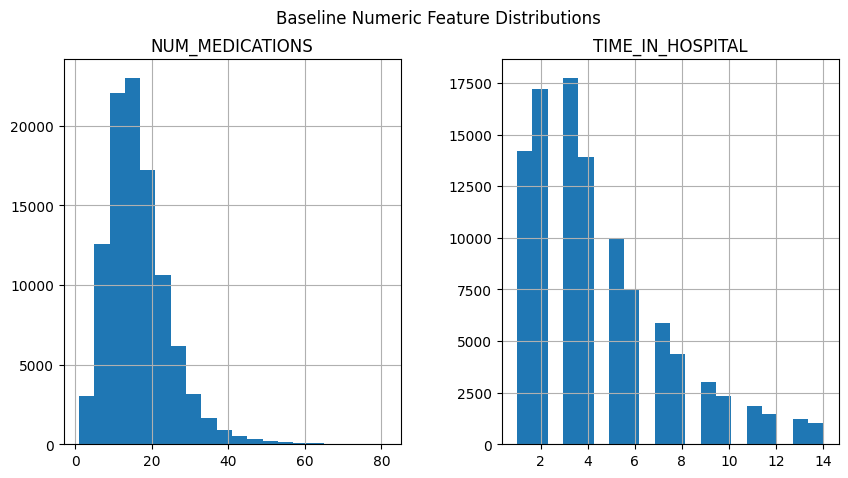

In [13]:
# Numeric features in baseline dataset
numeric = ['NUM_MEDICATIONS', 'TIME_IN_HOSPITAL']

# Plot histograms
df_baseline[numeric].hist(bins=20, figsize=(10,5))
plt.suptitle("Baseline Numeric Feature Distributions")
plt.show()


Target vs Key features

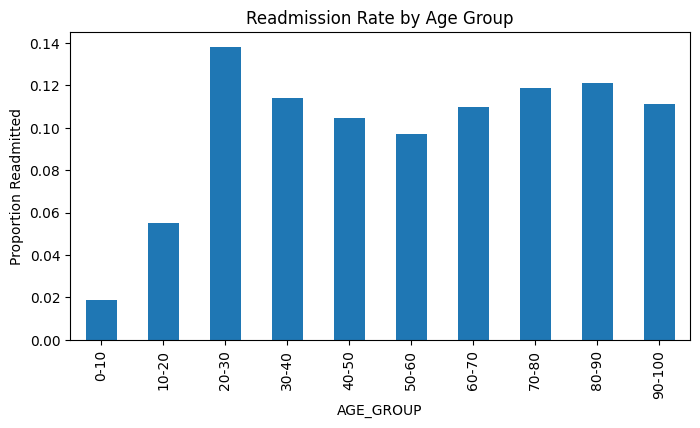

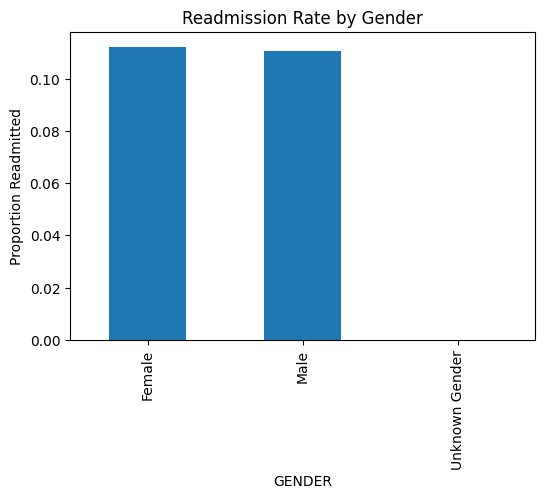

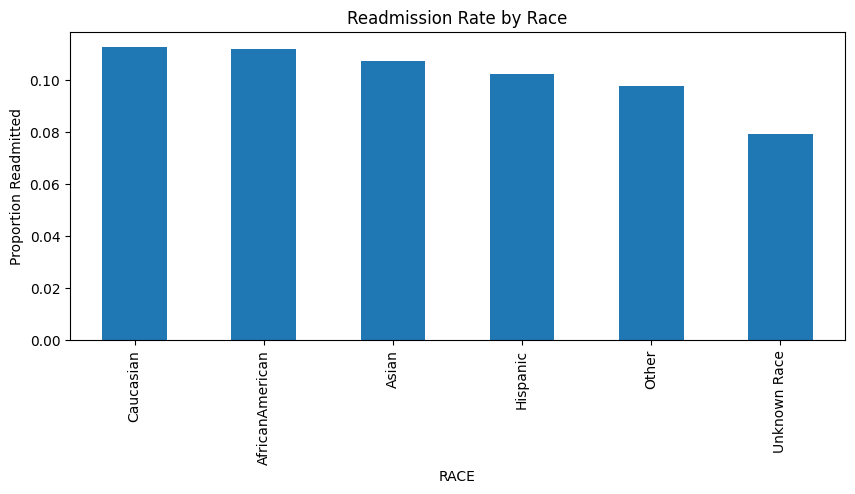

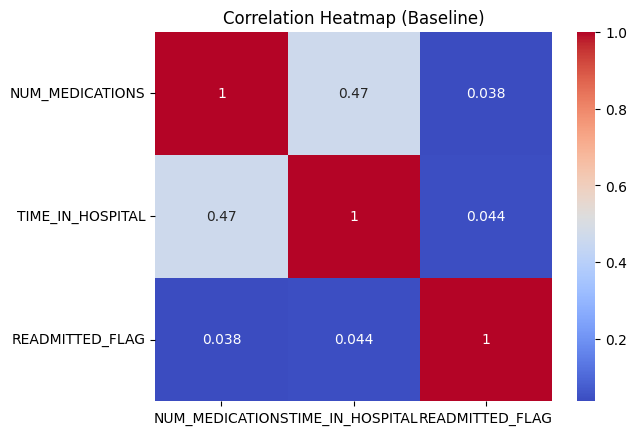

In [14]:
# Readmission rate by Age Group
df_baseline.groupby('AGE_GROUP')['READMITTED_FLAG'].mean().plot(
    kind='bar', figsize=(8,4), title="Readmission Rate by Age Group"
)
plt.ylabel("Proportion Readmitted")
plt.show()

# Readmission rate by Gender
df_baseline.groupby('GENDER')['READMITTED_FLAG'].mean().plot(
    kind='bar', figsize=(6,4), title="Readmission Rate by Gender"
)
plt.ylabel("Proportion Readmitted")
plt.show()

# Readmission rate by Race
df_baseline.groupby('RACE')['READMITTED_FLAG'].mean().sort_values(ascending=False).plot(
    kind='bar', figsize=(10,4), title="Readmission Rate by Race"
)
plt.ylabel("Proportion Readmitted")
plt.show()

# Correlation heatmap (numeric only)
sns.heatmap(
    df_baseline[['NUM_MEDICATIONS', 'TIME_IN_HOSPITAL', 'READMITTED_FLAG']].corr(),
    annot=True, cmap='coolwarm'
)
plt.title("Correlation Heatmap (Baseline)")
plt.show()


Class Imbalance Check

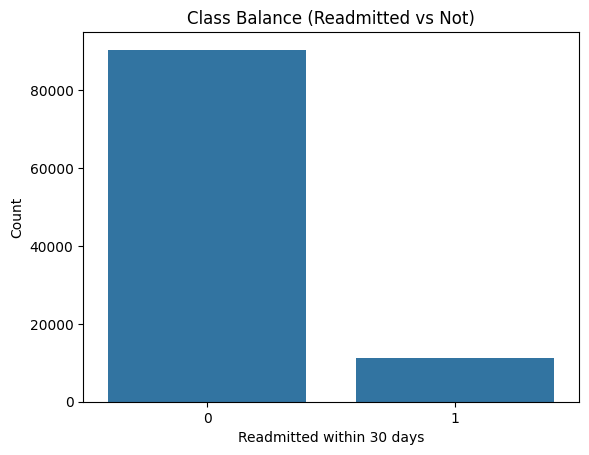

In [15]:
sns.countplot(x='READMITTED_FLAG', data=df_baseline)
plt.title("Class Balance (Readmitted vs Not)")
plt.xlabel("Readmitted within 30 days")
plt.ylabel("Count")
plt.show()


In [16]:
for col in ['RACE', 'GENDER', 'AGE_GROUP']:
    print("\n", col)
    print(df_baseline[col].value_counts(normalize=True))



 RACE
RACE
Caucasian          0.748236
AfricanAmerican    0.189022
Unknown Race       0.021638
Hispanic           0.019741
Other              0.014789
Asian              0.006574
Name: proportion, dtype: float64

 GENDER
GENDER
Female            0.537557
Male              0.462414
Unknown Gender    0.000029
Name: proportion, dtype: float64

 AGE_GROUP
AGE_GROUP
70-80     0.255979
60-70     0.219906
80-90     0.173201
50-60     0.167394
40-50     0.093243
30-40     0.036545
90-100    0.029578
20-30     0.015997
10-20     0.006584
0-10      0.001572
Name: proportion, dtype: float64


### Splitting the dataset for Modeling

Splitting Data on Patient ID using the main df, and then subsetting with baseline df

In [17]:
# Step 1: get unique patients
unique_patients = df['PATIENT_ID'].unique()

# Step 2: split patients into train/test sets (80/20)
train_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=42
)

# Step 3: assign encounters based on patient split
train_df = df[df['PATIENT_ID'].isin(train_patients)].copy()
test_df  = df[df['PATIENT_ID'].isin(test_patients)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Step 4: check readmission balance
print("Train readmission rate:", train_df['READMITTED_FLAG'].mean())
print("Test readmission rate:", test_df['READMITTED_FLAG'].mean())

Train shape: (81477, 16)
Test shape: (20289, 16)
Train readmission rate: 0.11276802042294144
Test readmission rate: 0.10690521957711074


In [18]:
# Define baseline feature set
baseline_cols = [
    "RACE", "GENDER", "AGE_GROUP",
    "NUM_MEDICATIONS", "TIME_IN_HOSPITAL",
    "READMITTED_FLAG"
]

# Create baseline train/test datasets
train_baseline = train_df[baseline_cols].copy()
test_baseline  = test_df[baseline_cols].copy()

print("Train baseline shape:", train_baseline.shape)
print("Test baseline shape:", test_baseline.shape)


Train baseline shape: (81477, 6)
Test baseline shape: (20289, 6)


### Baseline Modeling

In [19]:
# Features
cat_features = ['RACE', 'GENDER', 'AGE_GROUP']
num_features = ['NUM_MEDICATIONS', 'TIME_IN_HOSPITAL']

X_train = train_baseline[cat_features + num_features]
y_train = train_baseline['READMITTED_FLAG']

X_test = test_baseline[cat_features + num_features]
y_test = test_baseline['READMITTED_FLAG']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

#### Logistic Regression

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.90      0.56      0.69     18120
           1       0.12      0.50      0.19      2169

    accuracy                           0.56     20289
   macro avg       0.51      0.53      0.44     20289
weighted avg       0.82      0.56      0.64     20289

AUC: 0.5479274739277212


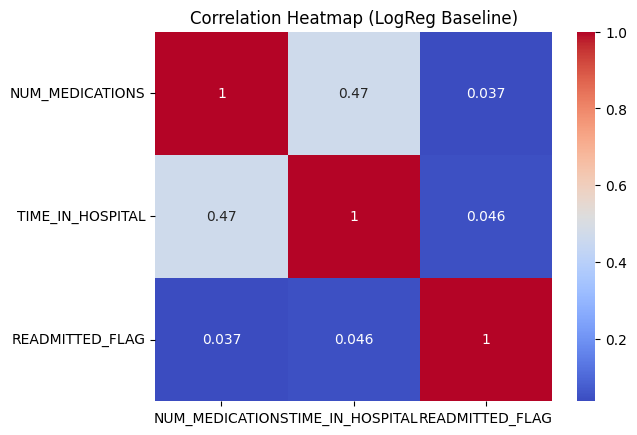

In [20]:
# Logistic Regression pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Fit + Predict
log_reg_pipeline.fit(X_train, y_train)
y_pred_lr = log_reg_pipeline.predict(X_test)
y_prob_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Reports
print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_prob_lr))

# Correlation heatmap for numeric features
sns.heatmap(train_baseline[num_features + ['READMITTED_FLAG']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (LogReg Baseline)")
plt.show()


#### XGBoost Classifier

XGBoost Results
              precision    recall  f1-score   support

           0       0.90      0.55      0.69     18120
           1       0.12      0.50      0.19      2169

    accuracy                           0.55     20289
   macro avg       0.51      0.53      0.44     20289
weighted avg       0.82      0.55      0.63     20289

AUC: 0.540013174808179


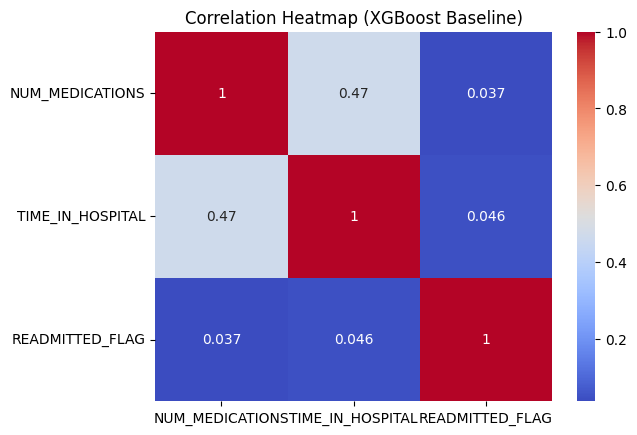

In [21]:
# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum()  # handle imbalance
    ))
])

# Fit + Predict
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Reports
print("XGBoost Results")
print(classification_report(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_prob_xgb))

# Correlation heatmap (same numeric features, for consistency)
sns.heatmap(train_baseline[num_features + ['READMITTED_FLAG']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (XGBoost Baseline)")
plt.show()


#### Random Forest Classifier

Random Forest Results
              precision    recall  f1-score   support

           0       0.90      0.70      0.79     18120
           1       0.11      0.32      0.17      2169

    accuracy                           0.66     20289
   macro avg       0.50      0.51      0.48     20289
weighted avg       0.81      0.66      0.72     20289

AUC: 0.5121989233194614


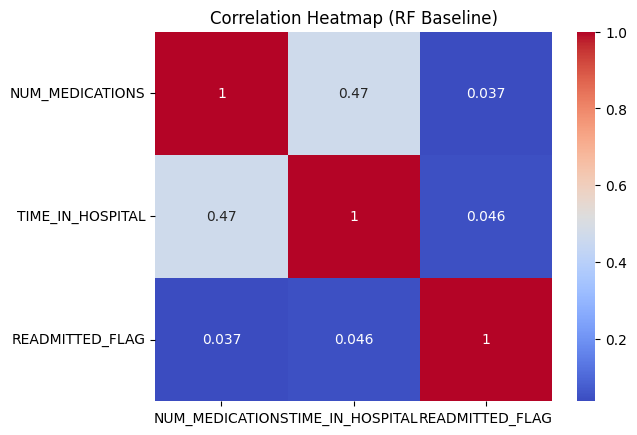

In [22]:
# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced"  # handle imbalance
    ))
])

# Fit + Predict
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Reports
print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))

# Correlation heatmap (same numeric features, for consistency)
sns.heatmap(train_baseline[num_features + ['READMITTED_FLAG']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (RF Baseline)")
plt.show()


#### Handling Class Imbalance

In [23]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train_baseline[train_baseline.READMITTED_FLAG == 0]
df_minority = train_baseline[train_baseline.READMITTED_FLAG == 1]

# Downsample majority class to match minority
df_majority_down = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

# Combine minority + downsampled majority
train_balanced = pd.concat([df_majority_down, df_minority])

print("Balanced train shape:", train_balanced.shape)
print(train_balanced.READMITTED_FLAG.value_counts(normalize=True))


# Features/target
X_train_bal = train_balanced[cat_features + num_features]
y_train_bal = train_balanced['READMITTED_FLAG']

Balanced train shape: (18376, 6)
READMITTED_FLAG
0    0.5
1    0.5
Name: proportion, dtype: float64


#### Prediction using Logistic Regression, RandomForest and XGBoost on Balanced Dataset

In [24]:
# Logistic Regression
log_reg_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg_bal.fit(X_train_bal, y_train_bal)
y_pred_lr_bal = log_reg_bal.predict(X_test)
y_prob_lr_bal = log_reg_bal.predict_proba(X_test)[:, 1]

print("Logistic Regression (Balanced Training)")
print(classification_report(y_test, y_pred_lr_bal))
print("AUC:", roc_auc_score(y_test, y_prob_lr_bal))


Logistic Regression (Balanced Training)
              precision    recall  f1-score   support

           0       0.90      0.55      0.68     18120
           1       0.12      0.51      0.19      2169

    accuracy                           0.55     20289
   macro avg       0.51      0.53      0.44     20289
weighted avg       0.82      0.55      0.63     20289

AUC: 0.5458344401393507


In [25]:
# Random Forest
rf_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_bal.fit(X_train_bal, y_train_bal)
y_pred_rf_bal = rf_bal.predict(X_test)
y_prob_rf_bal = rf_bal.predict_proba(X_test)[:, 1]

print("Random Forest (Balanced Training)")
print(classification_report(y_test, y_pred_rf_bal))
print("AUC:", roc_auc_score(y_test, y_prob_rf_bal))


Random Forest (Balanced Training)
              precision    recall  f1-score   support

           0       0.90      0.51      0.65     18120
           1       0.11      0.52      0.18      2169

    accuracy                           0.51     20289
   macro avg       0.51      0.51      0.42     20289
weighted avg       0.81      0.51      0.60     20289

AUC: 0.520834401973626


In [26]:
# XGBoost
xgb_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=1  # since we already balanced
    ))
])

xgb_bal.fit(X_train_bal, y_train_bal)
y_pred_xgb_bal = xgb_bal.predict(X_test)
y_prob_xgb_bal = xgb_bal.predict_proba(X_test)[:, 1]

print("XGBoost (Balanced Training)")
print(classification_report(y_test, y_pred_xgb_bal))
print("AUC:", roc_auc_score(y_test, y_prob_xgb_bal))


XGBoost (Balanced Training)
              precision    recall  f1-score   support

           0       0.90      0.48      0.63     18120
           1       0.12      0.56      0.19      2169

    accuracy                           0.49     20289
   macro avg       0.51      0.52      0.41     20289
weighted avg       0.82      0.49      0.58     20289

AUC: 0.5388164885090636


Multiple imbalance handling strategies were tested on the baseline dataset (undersampling, class weights, SMOTE, and threshold tuning). Across all models (Logistic Regression, Random Forest, XGBoost), AUC scores remained in the 0.52–0.55 range with very low precision (~0.12).
Conclusion: The weak signal in baseline features limits performance. Further tuning cannot meaningfully improve results.
Therefore, we proceed to the next stage– Enriched Dataset, where additional clinical and administrative features are included.

### Enriching Dataset and Modeling

#### Pulling the Enriched dataset from Snowflake

In [27]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user="SRITV",
    password="Pw",
    account="nib97747.us-west-2",   # e.g. abcd-xy12345.us-east-1
    warehouse="COMPUTE_WH",
    database="HOSPITAL_DB",
    schema="ANALYTICS",
    role="HOSPITAL_ROLE"
)


In [28]:
query_visits = """
SELECT
    f.ENCOUNTER_ID,
    f.PATIENT_ID,
    p.RACE,
    p.GENDER,
    p.AGE_GROUP,
    d1.DIAGNOSIS_CATEGORY AS PRIMARY_DIAGNOSIS,
    d2.DIAGNOSIS_CATEGORY AS SECONDARY_DIAGNOSIS,
    d3.DIAGNOSIS_CATEGORY AS TERTIARY_DIAGNOSIS,
    f.PAYER_CODE,
    f.ADMISSION_TYPE_ID,
    f.DISCHARGE_DISPOSITION_ID,
    f.MEDICAL_SPECIALTY,
    f.TIME_IN_HOSPITAL,
    f.NUM_LAB_PROCEDURES,
    f.NUM_PROCEDURES,
    f.NUM_MEDICATIONS,
    f.NUMBER_INPATIENT,
    f.NUMBER_OUTPATIENT,
    f.NUMBER_EMERGENCY,
    f.MAX_GLU_SERUM,
    f.A1CRESULT,
    f.CHANGE_FLAG,
    f.DIABETESMED,
    f.READMITTED_FLAG
FROM FACT_VISITS f
LEFT JOIN DIM_PATIENTS p ON f.PATIENT_ID = p.PATIENT_ID
LEFT JOIN DIM_DIAGNOSIS d1 ON f.DIAG1_ID = d1.DIAGNOSIS_ID
LEFT JOIN DIM_DIAGNOSIS d2 ON f.DIAG2_ID = d2.DIAGNOSIS_ID
LEFT JOIN DIM_DIAGNOSIS d3 ON f.DIAG3_ID = d3.DIAGNOSIS_ID;
"""

df_visits = pd.read_sql(query_visits, conn)


/tmp/ipython-input-528847621.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_visits = pd.read_sql(query_visits, conn)


In [29]:
query_meds = """
SELECT ENCOUNTER_ID, MEDICATION, STATUS
FROM FACT_MEDICATIONS;
"""

df_meds = pd.read_sql(query_meds, conn)


/tmp/ipython-input-2780313798.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_meds = pd.read_sql(query_meds, conn)


In [30]:
df_meds_pivot = df_meds.pivot_table(
    index="ENCOUNTER_ID",
    columns="MEDICATION",
    values="STATUS",
    aggfunc="first"   # one status per encounter-med combo
).reset_index()


In [31]:
df_enriched = df_visits.merge(df_meds_pivot, on="ENCOUNTER_ID", how="left")

df_enriched.head()

,ENCOUNTER_ID,PATIENT_ID,RACE,GENDER,AGE_GROUP,PRIMARY_DIAGNOSIS,SECONDARY_DIAGNOSIS,TERTIARY_DIAGNOSIS,PAYER_CODE,ADMISSION_TYPE_ID,...,metformin_pioglitazone,metformin_rosiglitazone,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone
0,2278392,10363,Caucasian,Female,0-10,Diabetes,Unknown,Unknown,Unknown,6,...,no,no,no,no,no,no,no,no,no,no
1,149190,38210,Caucasian,Female,10-20,Other,Diabetes,Other,Unknown,1,...,no,no,no,no,no,no,no,no,no,no
2,64410,52512,AfricanAmerican,Female,20-30,Other,Diabetes,Other,Unknown,1,...,no,no,no,no,no,no,no,no,no,no
3,500364,49788,Caucasian,Male,30-40,Other,Diabetes,Circulatory,Unknown,1,...,no,no,no,no,no,no,no,no,no,no
4,16680,32263,Caucasian,Male,40-50,Neoplasms,Neoplasms,Diabetes,Unknown,1,...,no,no,no,no,no,no,no,no,no,no


In [32]:
conn.close()


In [33]:
df_enriched.columns

Index(['ENCOUNTER_ID', 'PATIENT_ID', 'RACE', 'GENDER', 'AGE_GROUP',
       'PRIMARY_DIAGNOSIS', 'SECONDARY_DIAGNOSIS', 'TERTIARY_DIAGNOSIS',
       'PAYER_CODE', 'ADMISSION_TYPE_ID', 'DISCHARGE_DISPOSITION_ID',
       'MEDICAL_SPECIALTY', 'TIME_IN_HOSPITAL', 'NUM_LAB_PROCEDURES',
       'NUM_PROCEDURES', 'NUM_MEDICATIONS', 'NUMBER_INPATIENT',
       'NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY', 'MAX_GLU_SERUM', 'A1CRESULT',
       'CHANGE_FLAG', 'DIABETESMED', 'READMITTED_FLAG', 'acarbose',
       'acetohexamide', 'chlorpropamide', 'citoglipton', 'examide',
       'glimepiride', 'glimepiride_pioglitazone', 'glipizide',
       'glipizide_metformin', 'glyburide', 'glyburide_metformin', 'insulin',
       'metformin', 'metformin_pioglitazone', 'metformin_rosiglitazone',
       'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide',
       'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone'],
      dtype='object')

#### Feature Categorization

In [34]:
# Drop (non-predictive identifiers)
drop_cols = ["ENCOUNTER_ID", "PATIENT_ID"]

# Target column
target_col = "READMITTED_FLAG"

# Categorical features
categorical_cols = [
    # Demographics
    "RACE", "GENDER", "AGE_GROUP",

    # Diagnoses
    "PRIMARY_DIAGNOSIS", "SECONDARY_DIAGNOSIS", "TERTIARY_DIAGNOSIS",

    # Admission / Context
    "PAYER_CODE", "ADMISSION_TYPE_ID", "DISCHARGE_DISPOSITION_ID", "MEDICAL_SPECIALTY",

    # Lab results
    "MAX_GLU_SERUM", "A1CRESULT",

    # Flags
    "CHANGE_FLAG", "DIABETESMED",

    # Medications (23 categorical features)
    "acarbose", "acetohexamide", "chlorpropamide", "citoglipton", "examide",
    "glimepiride", "glimepiride_pioglitazone", "glipizide", "glipizide_metformin",
    "glyburide", "glyburide_metformin", "insulin", "metformin",
    "metformin_pioglitazone", "metformin_rosiglitazone", "miglitol",
    "nateglinide", "pioglitazone", "repaglinide", "rosiglitazone",
    "tolazamide", "tolbutamide", "troglitazone"
]

# Numerical features
numeric_cols = [
    "TIME_IN_HOSPITAL", "NUM_LAB_PROCEDURES", "NUM_PROCEDURES", "NUM_MEDICATIONS",
    "NUMBER_INPATIENT", "NUMBER_OUTPATIENT", "NUMBER_EMERGENCY"
]

# Split Features & Target
X = df_enriched.drop(columns=drop_cols + [target_col])
y = df_enriched[target_col]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

print("\nCategorical columns:", len(categorical_cols))
print("Numeric columns:", len(numeric_cols))


Shape of X: (101766, 44)
Shape of y: (101766,)

Categorical columns: 37
Numeric columns: 7


Splitting the dataset at unique patient level

In [35]:
# Patient-level split
unique_patients = df_enriched["PATIENT_ID"].unique()

train_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=42
)

train_mask = df_enriched["PATIENT_ID"].isin(train_patients)
test_mask = df_enriched["PATIENT_ID"].isin(test_patients)

df_train = df_enriched[train_mask].copy()
df_test = df_enriched[test_mask].copy()

print("Train shape:", df_train.shape, "Test shape:", df_test.shape)


# Define features & target
drop_cols = ["ENCOUNTER_ID", "PATIENT_ID"]
target_col = "READMITTED_FLAG"

X_train = df_train.drop(columns=drop_cols + [target_col])
y_train = df_train[target_col]

X_test = df_test.drop(columns=drop_cols + [target_col])
y_test = df_test[target_col]

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

# Preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# Fit & Transform

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed Train shape:", X_train_processed.shape)
print("Processed Test shape:", X_test_processed.shape)


Train shape: (81477, 47) Test shape: (20289, 47)
X_train shape: (81477, 44) X_test shape: (20289, 44)
Processed Train shape: (81477, 202)
Processed Test shape: (20289, 202)


#### Logistic Regression Modeling

In [36]:
# Define model
log_reg = LogisticRegression(
    max_iter=500,
    class_weight='balanced',   # handle class imbalance (~11% positive)
    solver='liblinear'         # good for sparse OneHot data
)

# Fit model
log_reg.fit(X_train_processed, y_train)

# Predictions
y_pred = log_reg.predict(X_test_processed)
y_prob = log_reg.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("Classification Report (Logistic Regression, Enriched Dataset):")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Classification Report (Logistic Regression, Enriched Dataset):
              precision    recall  f1-score   support

           0     0.9294    0.6832    0.7875     18120
           1     0.1762    0.5662    0.2688      2169

    accuracy                         0.6707     20289
   macro avg     0.5528    0.6247    0.5281     20289
weighted avg     0.8488    0.6707    0.7320     20289

ROC-AUC: 0.6710464380183542


Results Summary (Logistic Regression, Enriched Dataset)

Accuracy: ~67%

ROC-AUC: ~0.67

Class 0 (not readmitted):

Precision = 0.93 (very few false positives)

Recall = 0.68 (misses some readmissions)

Class 1 (readmitted <30 days):

Precision = 0.18 (many false positives)

Recall = 0.57 (recovers > half of true readmissions



*   Model is heavily biased toward the majority class (0), as expected with imbalance. Using class_weight="balanced" improved recall for Class 1 (0.57) but precision is low (0.18). ROC-AUC ~0.67 → better than random (0.5), but not strong



In [37]:
# Get feature names from the preprocessor
ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(categorical_cols)

# Combine categorical + numeric feature names
all_features = list(cat_features) + numeric_cols

print("Total features after encoding:", len(all_features))
print("Sample feature names:", all_features[:20])  # preview first 20


Total features after encoding: 202
Sample feature names: ['RACE_AfricanAmerican', 'RACE_Asian', 'RACE_Caucasian', 'RACE_Hispanic', 'RACE_Other', 'RACE_Unknown Race', 'GENDER_Female', 'GENDER_Male', 'GENDER_Unknown Gender', 'AGE_GROUP_0-10', 'AGE_GROUP_10-20', 'AGE_GROUP_20-30', 'AGE_GROUP_30-40', 'AGE_GROUP_40-50', 'AGE_GROUP_50-60', 'AGE_GROUP_60-70', 'AGE_GROUP_70-80', 'AGE_GROUP_80-90', 'AGE_GROUP_90-100', 'PRIMARY_DIAGNOSIS_Circulatory']


In [38]:
# Extract coefficients from logistic regression
coefs = log_reg.coef_[0]

# Create DataFrame of features + coefficients
coef_df = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": coefs
})

# Sort by absolute value (strongest predictors first)
coef_df["AbsCoef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="AbsCoef", ascending=False)

# Show top 15
print(coef_df.head(15))


                         Feature  Coefficient   AbsCoef
72   DISCHARGE_DISPOSITION_ID_11    -4.979537  4.979537
76   DISCHARGE_DISPOSITION_ID_15     1.832431  1.832431
88   DISCHARGE_DISPOSITION_ID_28     1.809173  1.809173
73   DISCHARGE_DISPOSITION_ID_12     1.566642  1.566642
83   DISCHARGE_DISPOSITION_ID_22     1.440122  1.440122
68           ADMISSION_TYPE_ID_7    -1.387619  1.387619
95    DISCHARGE_DISPOSITION_ID_9     1.323341  1.323341
78   DISCHARGE_DISPOSITION_ID_17    -1.242706  1.242706
77   DISCHARGE_DISPOSITION_ID_16    -1.102782  1.102782
91    DISCHARGE_DISPOSITION_ID_5     1.071432  1.071432
9                 AGE_GROUP_0-10    -0.945750  0.945750
74   DISCHARGE_DISPOSITION_ID_13    -0.924202  0.924202
80   DISCHARGE_DISPOSITION_ID_19    -0.907081  0.907081
180             repaglinide_down    -0.801357  0.801357
134            chlorpropamide_up    -0.796451  0.796451


Strongest negative predictor: DISCHARGE_DISPOSITION_ID_11 (coef = –4.98) → this discharge type is strongly associated with reduced readmission risk.

Strong positive predictors:

DISCHARGE_DISPOSITION_ID_15 (+1.83)

DISCHARGE_DISPOSITION_ID_28 (+1.81)
→ these discharge categories are highly associated with increased readmission risk.

Admission Type 7 (–1.38): Certain admission types correlate with lower risk.

Medication effect: repaglinide_down (–0.80) and chlorpropamide_up (–0.79) show meaningful associations with readmission risk, though less strong than discharge types.

Young age group (0–10): Negative coefficient (–0.95) → children are less likely to be readmitted within 30 days compared to older groups.

#### XGBoost Classifier

In [39]:
import xgboost as xgb

# Define model
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # imbalance handling
    random_state=42,
    n_jobs=-1
)

# Fit
xgb_model.fit(X_train_processed, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_processed)
y_prob_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("Classification Report (XGBoost, Enriched Dataset):")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


Classification Report (XGBoost, Enriched Dataset):
              precision    recall  f1-score   support

           0     0.9298    0.6977    0.7972     18120
           1     0.1814    0.5597    0.2740      2169

    accuracy                         0.6830     20289
   macro avg     0.5556    0.6287    0.5356     20289
weighted avg     0.8498    0.6830    0.7413     20289

ROC-AUC: 0.6770372863864386


#### SMOTE - Oversampling

In [40]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_processed, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_bal))


Before SMOTE: Counter({0: 72289, 1: 9188})
After SMOTE: Counter({0: 72289, 1: 72289})


In [41]:
xgb_smote = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_smote.fit(X_train_bal, y_train_bal)

# Predictions
y_prob_smote = xgb_smote.predict_proba(X_test_processed)[:, 1]
y_pred_default = (y_prob_smote >= 0.5).astype(int)

print("Classification Report (XGBoost + SMOTE, threshold=0.5):")
print(classification_report(y_test, y_pred_default, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob_smote))


Classification Report (XGBoost + SMOTE, threshold=0.5):
              precision    recall  f1-score   support

           0     0.8941    0.9991    0.9437     18120
           1     0.6098    0.0115    0.0226      2169

    accuracy                         0.8935     20289
   macro avg     0.7519    0.5053    0.4832     20289
weighted avg     0.8637    0.8935    0.8452     20289

ROC-AUC: 0.6846680905026375


Model with SMOTE collapsed, with the model detecting eve rything as not readmitted

#### Under Sampling

In [42]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Initialize undersampler
undersample = RandomUnderSampler(random_state=42)

# Apply to training set only
X_train_bal, y_train_bal = undersample.fit_resample(X_train_processed, y_train)

print("Before undersampling:", Counter(y_train))
print("After undersampling:", Counter(y_train_bal))


xgb_us = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_us.fit(X_train_bal, y_train_bal)

# Predictions
y_pred_us = xgb_us.predict(X_test_processed)
y_prob_us = xgb_us.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("Classification Report (XGBoost, Undersampled):")
print(classification_report(y_test, y_pred_us, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob_us))


Before undersampling: Counter({0: 72289, 1: 9188})
After undersampling: Counter({0: 9188, 1: 9188})
Classification Report (XGBoost, Undersampled):
              precision    recall  f1-score   support

           0     0.9310    0.6452    0.7622     18120
           1     0.1684    0.6003    0.2630      2169

    accuracy                         0.6404     20289
   macro avg     0.5497    0.6227    0.5126     20289
weighted avg     0.8494    0.6404    0.7088     20289

ROC-AUC: 0.6706040845467489


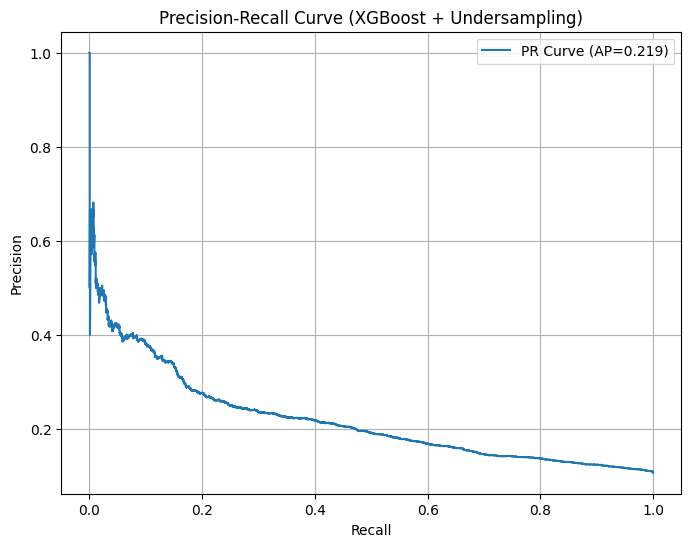

In [43]:
# Get probabilities from undersampled XGBoost model
y_prob_us = xgb_us.predict_proba(X_test_processed)[:, 1]

# Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_us)
avg_prec = average_precision_score(y_test, y_prob_us)

plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label=f'PR Curve (AP={avg_prec:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost + Undersampling)")
plt.legend()
plt.grid(True)
plt.show()


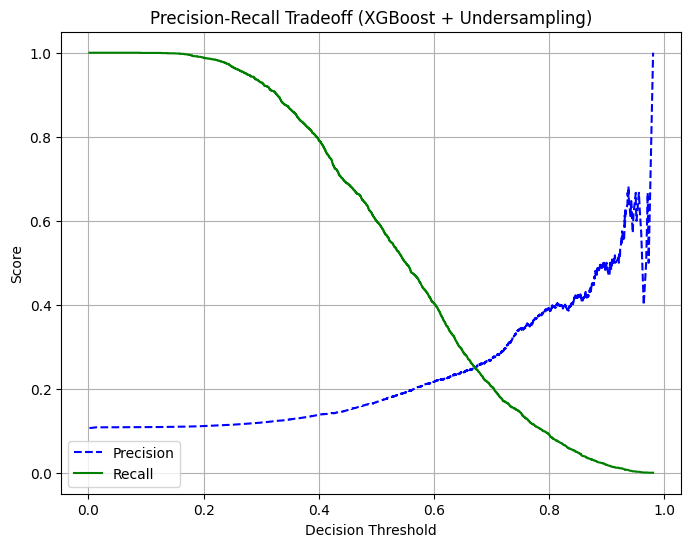

Threshold 0.2: Precision=0.1115, Recall=0.9885, F1=0.2004
Threshold 0.3: Precision=0.1199, Recall=0.9295, F1=0.2123
Threshold 0.4: Precision=0.1377, Recall=0.7907, F1=0.2345
Threshold 0.5: Precision=0.1684, Recall=0.6003, F1=0.2630


In [44]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff (XGBoost + Undersampling)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Assessing performance and different thresholds
for t in [0.2, 0.3, 0.4, 0.5]:
    y_pred_t = (y_prob_us >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_t, average="binary")
    print(f"Threshold {t}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


Hyperparameter Tuning to improve overall performance

In [45]:
# Define parameter grid
param_grid = {
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [200, 400, 600],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.3]
}

# Initialize model
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search setup (30 iterations for efficiency)
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=30,
    scoring="roc_auc",   # primary metric
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)


In [46]:
# Fit RandomizedSearchCV on the undersampled training set
random_search.fit(X_train_bal, y_train_bal)

# Best parameters from the search
print("Best Parameters:", random_search.best_params_)

# Best cross-validated ROC-AUC score
print("Best CV ROC-AUC:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best CV ROC-AUC: 0.6687784784315061


In [47]:
# Refit tuned XGBoost model
best_params = random_search.best_params_

xgb_best = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_best.fit(X_train_bal, y_train_bal)

# Predictions on test set
y_pred_best = xgb_best.predict(X_test_processed)
y_prob_best = xgb_best.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("ROC-AUC on Test Set:", roc_auc_score(y_test, y_prob_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, digits=4))


ROC-AUC on Test Set: 0.6843179327000877

Classification Report:
               precision    recall  f1-score   support

           0     0.9335    0.6578    0.7718     18120
           1     0.1755    0.6086    0.2725      2169

    accuracy                         0.6526     20289
   macro avg     0.5545    0.6332    0.5221     20289
weighted avg     0.8525    0.6526    0.7184     20289



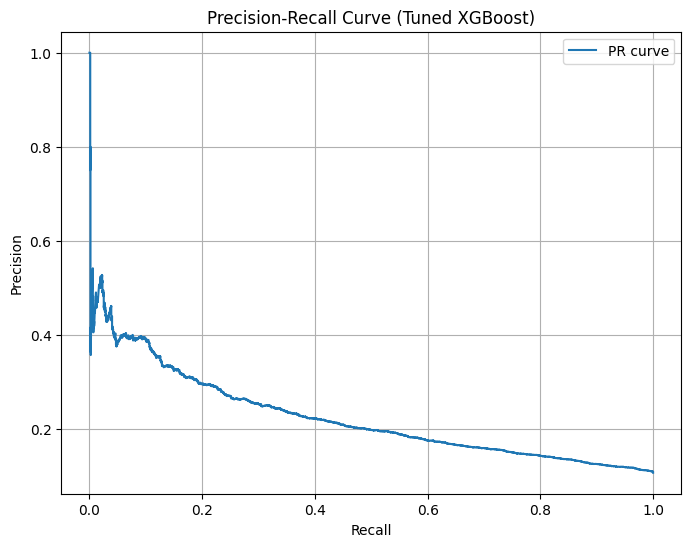

In [49]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_best)

# Plot PR curve
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Tuned XGBoost)")
plt.grid(True)
plt.legend()
plt.show()


#### Scale Pos Weight - without sampling

In [50]:
# Ratio of negatives to positives in the training set
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# Model with tuned params + scale_pos_weight
xgb_weighted = xgb.XGBClassifier(
    **best_params,  # reuse tuned params from RandomizedSearchCV
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# Fit on full (original) processed training set (not undersampled)
xgb_weighted.fit(X_train_processed, y_train)

# Evaluate on untouched test set
y_pred_weighted = xgb_weighted.predict(X_test_processed)
y_prob_weighted = xgb_weighted.predict_proba(X_test_processed)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_weighted))
print("\nClassification Report:\n", classification_report(y_test, y_pred_weighted, digits=4))


scale_pos_weight: 7.867762298650414
ROC-AUC: 0.6869885665666216

Classification Report:
               precision    recall  f1-score   support

           0     0.9332    0.6620    0.7745     18120
           1     0.1762    0.6040    0.2728      2169

    accuracy                         0.6558     20289
   macro avg     0.5547    0.6330    0.5237     20289
weighted avg     0.8522    0.6558    0.7209     20289



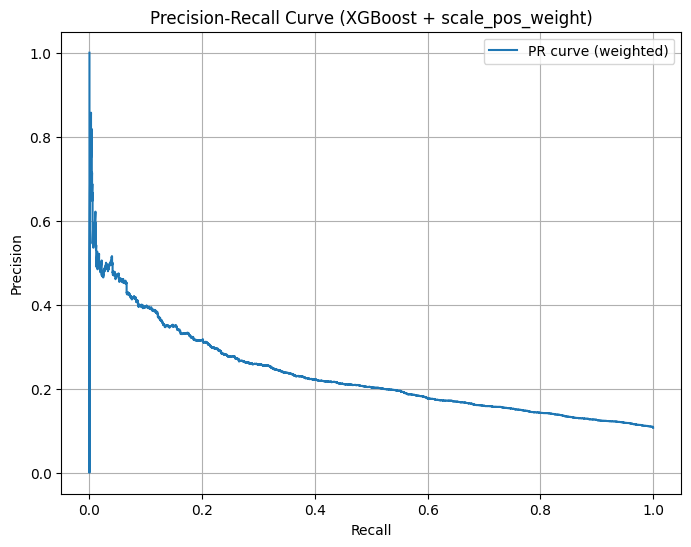

Threshold=0.501, Precision=0.177, Recall=0.600
Threshold=0.501, Precision=0.177, Recall=0.600
Threshold=0.501, Precision=0.177, Recall=0.602
Threshold=0.501, Precision=0.177, Recall=0.601
Threshold=0.501, Precision=0.177, Recall=0.600

Best Threshold (by F1): 0.544
Max F1: 0.29069440539780717


In [51]:
# Precision-Recall curve
precisions_w, recalls_w, thresholds_w = precision_recall_curve(y_test, y_prob_weighted)

# Plot
plt.figure(figsize=(8,6))
plt.plot(recalls_w, precisions_w, label="PR curve (weighted)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost + scale_pos_weight)")
plt.grid(True)
plt.legend()
plt.show()

# Find thresholds with recall in 0.60–0.70 range
candidates_w = [(t, p, r) for p, r, t in zip(precisions_w, recalls_w, thresholds_w) if 0.60 <= r <= 0.70]

# Sort by precision and show top 5
candidates_sorted_w = sorted(candidates_w, key=lambda x: x[1], reverse=True)[:5]
for t, p, r in candidates_sorted_w:
    print(f"Threshold={t:.3f}, Precision={p:.3f}, Recall={r:.3f}")

# Find best threshold by F1
f1_scores_w = []
for t in thresholds_w:
    preds = (y_prob_weighted >= t).astype(int)
    f1_scores_w.append(f1_score(y_test, preds))

best_t_w = thresholds_w[np.argmax(f1_scores_w)]
print(f"\nBest Threshold (by F1): {best_t_w:.3f}")
print("Max F1:", max(f1_scores_w))


In [52]:
# Apply custom threshold
y_pred_thresh = (y_prob_weighted >= 0.544).astype(int)

print("Classification Report (Threshold=0.544):")
print(classification_report(y_test, y_pred_thresh, digits=4))


Classification Report (Threshold=0.544):
              precision    recall  f1-score   support

           0     0.9260    0.7834    0.8488     18120
           1     0.2087    0.4772    0.2904      2169

    accuracy                         0.7507     20289
   macro avg     0.5673    0.6303    0.5696     20289
weighted avg     0.8493    0.7507    0.7891     20289



Hyperparameter Tuning Results & Scenario-Based Recommendations

After tuning XGBoost on the undersampled dataset and experimenting with class weighting (scale_pos_weight), we obtained the following results on the untouched test set:

Key Results

1. Undersampled Model (Threshold = 0.5)

ROC-AUC: 0.684

Precision (Readmission): 0.176

Recall (Readmission): 0.609

F1 (Readmission): 0.273

Interpretation: Captures ~61% of readmissions but with many false alarms (low precision).

2. Weighted Model (scale_pos_weight, Threshold = 0.5)

ROC-AUC: 0.687

Precision: 0.176

Recall: 0.604

F1: 0.273

Interpretation: Nearly identical performance to undersampling, but uses all training data (no data discarded).

3. Weighted Model (F1-Optimal Threshold = 0.544)

ROC-AUC: 0.687

Precision: 0.209

Recall: 0.477

F1: 0.290

Interpretation: Improves precision (≈21%) and overall F1, but recall drops to ~48%.

| Model Variant                     | Threshold | Precision (Readmission) | Recall (Readmission) | F1 (Readmission) | ROC-AUC |
| --------------------------------- | --------- | ----------------------- | -------------------- | ---------------- | ------- |
| **Undersampled**                  | 0.50      | 0.176                   | **0.609**            | 0.273            | 0.684   |
| **Weighted (`scale_pos_weight`)** | 0.50      | 0.176                   | **0.604**            | 0.273            | 0.687   |
| **Weighted (F1-optimal)**         | 0.544     | **0.209**               | 0.477                | **0.290**        | 0.687   |


**Scenario-Based Use Cases**

***Scenario 1***: High Recall (Hospital wants to catch as many readmissions as possible)

Recommended: Weighted Model @ 0.5

Recall ≈ 60% → most at-risk patients are flagged.

Precision ≈ 18% → false alarms are high but acceptable if preventing missed readmissions is the top priority.

***Scenario 2***: Higher Precision (Hospital wants to reduce false alarms, limited resources)

Recommended: Weighted Model @ 0.544

Precision ≈ 21% → more reliable flags.

Recall ≈ 48% → misses some readmissions, but interventions are more targeted.



#### Feature Importance

In [53]:
# 1. Get categorical feature names (expanded from OneHotEncoder)
ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(categorical_cols)

# 2. Numeric features (scaler does not change names)
num_features = numeric_cols

# 3. Combine
feature_names = np.concatenate([cat_features, num_features])

print("Total features:", len(feature_names))  # should match 202


Total features: 202


In [54]:
# Importance values from your trained model
importances = xgb_weighted.feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Show top 20
feature_importance_df.head(20)


,feature,importance
70,DISCHARGE_DISPOSITION_ID_1,0.061201
199,NUMBER_INPATIENT,0.052830
72,DISCHARGE_DISPOSITION_ID_11,0.027323
83,DISCHARGE_DISPOSITION_ID_22,0.026901
89,DISCHARGE_DISPOSITION_ID_3,0.018192
201,NUMBER_EMERGENCY,0.013905
91,DISCHARGE_DISPOSITION_ID_5,0.012792
81,DISCHARGE_DISPOSITION_ID_2,0.010367
26,PRIMARY_DIAGNOSIS_Other,0.010185
88,DISCHARGE_DISPOSITION_ID_28,0.010181


In [55]:
# Manually pick top features from importance ranking
top_features = [
    "DISCHARGE_DISPOSITION_ID_1",
    "NUMBER_INPATIENT",
    "DISCHARGE_DISPOSITION_ID_11",
    "DISCHARGE_DISPOSITION_ID_22",
    "DISCHARGE_DISPOSITION_ID_3",
    "NUMBER_EMERGENCY",
    "DISCHARGE_DISPOSITION_ID_5",
    "DISCHARGE_DISPOSITION_ID_2",
    "PRIMARY_DIAGNOSIS_Other",
    "DISCHARGE_DISPOSITION_ID_28",
    "PRIMARY_DIAGNOSIS_Musculoskeletal",
    "DISCHARGE_DISPOSITION_ID_13",
    "TERTIARY_DIAGNOSIS_Unknown",
    "DIABETESMED_no",
    "PRIMARY_DIAGNOSIS_Circulatory",
    "DISCHARGE_DISPOSITION_ID_23",
    "AGE_GROUP_50-60",
    "TIME_IN_HOSPITAL",
    "TERTIARY_DIAGNOSIS_Neoplasms",
    "DISCHARGE_DISPOSITION_ID_6"
]

# Convert sparse matrix to dense array
X_train_dense = X_train_processed.toarray()
X_test_dense  = X_test_processed.toarray()

# Build DataFrames with correct feature names
X_train_df = pd.DataFrame(X_train_dense, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_dense,  columns=feature_names)

print("Train DF shape:", X_train_df.shape)
print("Test DF shape:", X_test_df.shape)


# Keep only top features
X_train_top = X_train_df[top_features]
X_test_top  = X_test_df[top_features]

print("Reduced Train shape:", X_train_top.shape)
print("Reduced Test shape:", X_test_top.shape)

Train DF shape: (81477, 202)
Test DF shape: (20289, 202)
Reduced Train shape: (81477, 20)
Reduced Test shape: (20289, 20)


**Modeling with important 20 features**

In [56]:
# Retrain tuned model on reduced features
xgb_reduced = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_reduced.fit(X_train_top, y_train)

# Predictions
y_pred_reduced = xgb_reduced.predict(X_test_top)
y_prob_reduced = xgb_reduced.predict_proba(X_test_top)[:, 1]

# Evaluation
print("ROC-AUC (Reduced Features):", roc_auc_score(y_test, y_prob_reduced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_reduced, digits=4))


ROC-AUC (Reduced Features): 0.6796812805771065

Classification Report:
               precision    recall  f1-score   support

           0     0.9340    0.6432    0.7618     18120
           1     0.1723    0.6206    0.2697      2169

    accuracy                         0.6407     20289
   macro avg     0.5532    0.6319    0.5157     20289
weighted avg     0.8526    0.6407    0.7092     20289



In [57]:
precisions_r, recalls_r, thresholds_r = precision_recall_curve(y_test, y_prob_reduced)

f1_scores_r = []
for t in thresholds_r:
    preds = (y_prob_reduced >= t).astype(int)
    f1_scores_r.append(f1_score(y_test, preds))

best_t_r = thresholds_r[np.argmax(f1_scores_r)]
print(f"Best Threshold (Reduced Features): {best_t_r:.3f}, Max F1={max(f1_scores_r):.3f}")


Best Threshold (Reduced Features): 0.586, Max F1=0.282


Training the best model and testing on unseen data - XGB with best threshold, reduced features and scale pos weight

In [58]:
# Convert sparse matrices to dense arrays
X_train_dense = X_train_processed.toarray()
X_test_dense  = X_test_processed.toarray()

# Build DataFrames with feature names
X_train_df = pd.DataFrame(X_train_dense, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_dense,  columns=feature_names)

# Select top 20 features
X_train_best = X_train_df[top_features]
X_test_best  = X_test_df[top_features]

# Define best model (tuned hyperparameters + class weighting)
xgb_best_final = xgb.XGBClassifier(
    **best_params,                   # your tuned params from RandomizedSearchCV
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# Train on reduced features
xgb_best_final.fit(X_train_best, y_train)

# Predict probabilities
y_prob_final = xgb_best_final.predict_proba(X_test_best)[:, 1]

# Apply best threshold (from Phase 9.3)
best_threshold = 0.586
y_pred_final = (y_prob_final >= best_threshold).astype(int)

# Final evaluation
print("ROC-AUC:", roc_auc_score(y_test, y_prob_final))
print("\nClassification Report(Best Threshold + Reduced Features):\n", classification_report(y_test, y_pred_final, digits=4))



ROC-AUC: 0.6796812805771065

Classification Report:
               precision    recall  f1-score   support

           0     0.9183    0.8499    0.8827     18120
           1     0.2268    0.3679    0.2806      2169

    accuracy                         0.7984     20289
   macro avg     0.5725    0.6089    0.5817     20289
weighted avg     0.8443    0.7984    0.8184     20289



#### CATBoost and Light BGM

In [59]:
!pip install catboost lightgbm


In [60]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score

# Train LightGBM on reduced features
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train_best, y_train)

# Predictions
y_prob_lgb = lgb_model.predict_proba(X_test_best)[:, 1]
y_pred_lgb = (y_prob_lgb >= 0.5).astype(int)

print("LightGBM ROC-AUC:", roc_auc_score(y_test, y_prob_lgb))
print("\nLightGBM Classification Report:\n", classification_report(y_test, y_pred_lgb, digits=4))


[LightGBM] [Info] Number of positive: 9188, number of negative: 72289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 81477, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112768 -> initscore=-2.062774
[LightGBM] [Info] Start training from score -2.062774
LightGBM ROC-AUC: 0.6786887554615152

LightGBM Classification Report:
               precision    recall  f1-score   support

           0     0.8943    0.9989    0.9437     18120
           1     0.6000    0.0138    0.0270      2169

    accuracy                         0.8936     20289
   macro avg     0.7472    0.5064    0.4854     20289
weighted avg     0.8628    0.8936    0.8457     20289



In [61]:
from catboost import CatBoostClassifier

# Train CatBoost on reduced features
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    eval_metric="AUC",
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_best, y_train)

# Predictions
y_prob_cat = cat_model.predict_proba(X_test_best)[:, 1]
y_pred_cat = (y_prob_cat >= 0.5).astype(int)

print("CatBoost ROC-AUC:", roc_auc_score(y_test, y_prob_cat))
print("\nCatBoost Classification Report:\n", classification_report(y_test, y_pred_cat, digits=4))


CatBoost ROC-AUC: 0.6805016782741358

CatBoost Classification Report:
               precision    recall  f1-score   support

           0     0.8939    0.9992    0.9436     18120
           1     0.5714    0.0092    0.0181      2169

    accuracy                         0.8933     20289
   macro avg     0.7327    0.5042    0.4809     20289
weighted avg     0.8594    0.8933    0.8447     20289



Scaled Pos Weight

In [62]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)  # ~7.87


scale_pos_weight: 7.867762298650414


In [63]:
lgb_model_w = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    scale_pos_weight=scale_pos_weight,  # class balancing
    random_state=42,
    n_jobs=-1
)

lgb_model_w.fit(X_train_best, y_train)

y_prob_lgb_w = lgb_model_w.predict_proba(X_test_best)[:, 1]
y_pred_lgb_w = (y_prob_lgb_w >= 0.5).astype(int)

print("LightGBM (weighted) ROC-AUC:", roc_auc_score(y_test, y_prob_lgb_w))
print("\nLightGBM (weighted) Report:\n", classification_report(y_test, y_pred_lgb_w, digits=4))


[LightGBM] [Info] Number of positive: 9188, number of negative: 72289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 81477, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112768 -> initscore=-2.062774
[LightGBM] [Info] Start training from score -2.062774
LightGBM (weighted) ROC-AUC: 0.6754780129804174

LightGBM (weighted) Report:
               precision    recall  f1-score   support

           0     0.9317    0.6651    0.7761     18120
           1     0.1748    0.5924    0.2699      2169

    accuracy                         0.6574     20289
   macro avg     0.5532    0.6288    0.5230     20289
weighted avg     0.8507    0.6574    0.7220     20289



In [64]:
cat_model_w = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    eval_metric="AUC",
    class_weights=[1.0, scale_pos_weight],  # weight negatives vs positives
    random_seed=42,
    verbose=0
)

cat_model_w.fit(X_train_best, y_train)

y_prob_cat_w = cat_model_w.predict_proba(X_test_best)[:, 1]
y_pred_cat_w = (y_prob_cat_w >= 0.5).astype(int)

print("CatBoost (weighted) ROC-AUC:", roc_auc_score(y_test, y_prob_cat_w))
print("\nCatBoost (weighted) Report:\n", classification_report(y_test, y_pred_cat_w, digits=4))


CatBoost (weighted) ROC-AUC: 0.6792092087278397

CatBoost (weighted) Report:
               precision    recall  f1-score   support

           0     0.9332    0.6579    0.7718     18120
           1     0.1751    0.6067    0.2718      2169

    accuracy                         0.6525     20289
   macro avg     0.5542    0.6323    0.5218     20289
weighted avg     0.8522    0.6525    0.7183     20289



#### Weighted Model Comparison (XGBoost vs LightGBM vs CatBoost)

With class weighting applied, all three boosting models performed similarly (ROC-AUC ≈ 0.68).  

| Model      | ROC-AUC | Precision (Readmission) | Recall (Readmission) | F1 (Readmission) |
|------------|---------|--------------------------|----------------------|------------------|
| **XGBoost** | 0.680 | 0.172 | **0.621** | 0.270 |
| **LightGBM** | 0.675 | 0.175 | 0.592 | 0.270 |
| **CatBoost** | 0.679 | 0.175 | 0.607 | **0.272** |

#### Insights
- **XGBoost** achieved the best recall (62%).  
- **CatBoost** achieved the best F1 (0.272) while maintaining recall close to XGBoost.  
- **LightGBM** performed slightly lower overall but was still competitive.  

#### Takeaway
All three boosting methods confirm the same signal in the data (ROC-AUC ≈ 0.68).  
- For interpretability and ecosystem → **XGBoost** remains the main choice.  
- For slightly better balance (F1), **CatBoost** shows promise.  

This comparison strengthens confidence that our results are not model-specific, but reflect the dataset’s underlying predictive signal.


### EBM - Interpret ML

In [65]:
!pip install interpret

In [66]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train EBM on reduced features
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train_best, y_train)

# Predictions
y_prob_ebm = ebm.predict_proba(X_test_best)[:, 1]
y_pred_ebm = ebm.predict(X_test_best)

# Evaluation
print("EBM ROC-AUC:", roc_auc_score(y_test, y_prob_ebm))
print("\nEBM Classification Report:\n", classification_report(y_test, y_pred_ebm, digits=4))

# Global feature importance
ebm_global = ebm.explain_global()
ebm_global.data()['names'][:10], ebm_global.data()['scores'][:10]


EBM ROC-AUC: 0.6792643200343593

EBM Classification Report:
               precision    recall  f1-score   support

           0     0.8940    0.9990    0.9435     18120
           1     0.5366    0.0101    0.0199      2169

    accuracy                         0.8932     20289
   macro avg     0.7153    0.5045    0.4817     20289
weighted avg     0.8558    0.8932    0.8448     20289



(['DISCHARGE_DISPOSITION_ID_1',
  'NUMBER_INPATIENT',
  'DISCHARGE_DISPOSITION_ID_11',
  'DISCHARGE_DISPOSITION_ID_22',
  'DISCHARGE_DISPOSITION_ID_3',
  'NUMBER_EMERGENCY',
  'DISCHARGE_DISPOSITION_ID_5',
  'DISCHARGE_DISPOSITION_ID_2',
  'PRIMARY_DIAGNOSIS_Other',
  'DISCHARGE_DISPOSITION_ID_28'],
 [np.float64(0.10885902957614578),
  np.float64(0.2860391088740591),
  np.float64(0.2121627804185478),
  np.float64(0.03986603095139749),
  np.float64(0.04217869805679365),
  np.float64(0.032044120652637995),
  np.float64(0.015350691690682408),
  np.float64(0.014917550837909901),
  np.float64(0.0035995472043635845),
  np.float64(0.004186258514693696)])

In [72]:
from interpret import show

# Global explanation (feature importance ranking)
ebm_global = ebm.explain_global()

# 1. View feature importance (numeric scores per feature)
for name, score in zip(ebm_global.data()['names'], ebm_global.data()['scores']):
    print(f"{name}: {score:.4f}")

# 2. Interactive visualization (opens in notebook if running locally/JupyterLab)
show(ebm_global)


DISCHARGE_DISPOSITION_ID_1: 0.1089
NUMBER_INPATIENT: 0.2860
DISCHARGE_DISPOSITION_ID_11: 0.2122
DISCHARGE_DISPOSITION_ID_22: 0.0399
DISCHARGE_DISPOSITION_ID_3: 0.0422
NUMBER_EMERGENCY: 0.0320
DISCHARGE_DISPOSITION_ID_5: 0.0154
DISCHARGE_DISPOSITION_ID_2: 0.0149
PRIMARY_DIAGNOSIS_Other: 0.0036
DISCHARGE_DISPOSITION_ID_28: 0.0042
PRIMARY_DIAGNOSIS_Musculoskeletal: 0.0172
DISCHARGE_DISPOSITION_ID_13: 0.0084
TERTIARY_DIAGNOSIS_Unknown: 0.0120
DIABETESMED_no: 0.0448
PRIMARY_DIAGNOSIS_Circulatory: 0.0370
DISCHARGE_DISPOSITION_ID_23: 0.0056
AGE_GROUP_50-60: 0.0314
TIME_IN_HOSPITAL: 0.0707
TERTIARY_DIAGNOSIS_Neoplasms: 0.0107
DISCHARGE_DISPOSITION_ID_6: 0.0018
DISCHARGE_DISPOSITION_ID_1 & NUMBER_INPATIENT: 0.0366
DISCHARGE_DISPOSITION_ID_1 & NUMBER_EMERGENCY: 0.0062
DISCHARGE_DISPOSITION_ID_1 & PRIMARY_DIAGNOSIS_Other: 0.0070
DISCHARGE_DISPOSITION_ID_1 & PRIMARY_DIAGNOSIS_Musculoskeletal: 0.0041
DISCHARGE_DISPOSITION_ID_1 & AGE_GROUP_50-60: 0.0094
DISCHARGE_DISPOSITION_ID_1 & TIME_IN_HOSPITAL:

In [73]:
# Example: show effect of discharge disposition
discharge_idx = ebm_global.data()['names'].index("DISCHARGE_DISPOSITION_ID_1")
show(ebm_global, discharge_idx)


In [74]:
# Explain interactions
ebm_interactions = ebm.explain_global(name='EBM Interactions')

# 1. Show top interactions with their importance scores
for name, score in zip(ebm_interactions.data()['names'], ebm_interactions.data()['scores']):
    print(f"Interaction: {name} | Importance: {score:.4f}")

# 2. Visualize one interaction (example: top ranked interaction)
show(ebm_interactions, 0)  # 0 = highest-ranked interaction


Interaction: DISCHARGE_DISPOSITION_ID_1 | Importance: 0.1089
Interaction: NUMBER_INPATIENT | Importance: 0.2860
Interaction: DISCHARGE_DISPOSITION_ID_11 | Importance: 0.2122
Interaction: DISCHARGE_DISPOSITION_ID_22 | Importance: 0.0399
Interaction: DISCHARGE_DISPOSITION_ID_3 | Importance: 0.0422
Interaction: NUMBER_EMERGENCY | Importance: 0.0320
Interaction: DISCHARGE_DISPOSITION_ID_5 | Importance: 0.0154
Interaction: DISCHARGE_DISPOSITION_ID_2 | Importance: 0.0149
Interaction: PRIMARY_DIAGNOSIS_Other | Importance: 0.0036
Interaction: DISCHARGE_DISPOSITION_ID_28 | Importance: 0.0042
Interaction: PRIMARY_DIAGNOSIS_Musculoskeletal | Importance: 0.0172
Interaction: DISCHARGE_DISPOSITION_ID_13 | Importance: 0.0084
Interaction: TERTIARY_DIAGNOSIS_Unknown | Importance: 0.0120
Interaction: DIABETESMED_no | Importance: 0.0448
Interaction: PRIMARY_DIAGNOSIS_Circulatory | Importance: 0.0370
Interaction: DISCHARGE_DISPOSITION_ID_23 | Importance: 0.0056
Interaction: AGE_GROUP_50-60 | Importance: 0

#### Explainable Boosting Machine (EBM)

EBM (Explainable Boosting Machine) is an inherently interpretable glass-box model.  
We trained it on the reduced 20-feature dataset.

- ROC-AUC: **0.679** (similar to XGBoost)
- Precision (Readmission): **0.537**
- Recall (Readmission): **0.010**
- F1 (Readmission): **0.020**
- Accuracy: **0.893**

#### Insights
- EBM identifies the same **key predictors** as XGBoost:
  - Discharge disposition (IDs 1, 11, 22, 3, 5, etc.)
  - Prior inpatient and emergency visits
  - Primary diagnoses (circulatory, musculoskeletal, other)

- However, EBM is **extremely conservative**:
  - Almost never predicts readmissions (very low recall).
  - High accuracy is misleading because it defaults to “not readmitted.”

### Takeaway
EBM confirms the **important clinical drivers** but cannot match XGBoost’s predictive power.  
We include it as an interpretability benchmark, but **XGBoost remains the best-performing model**.


### SHAP

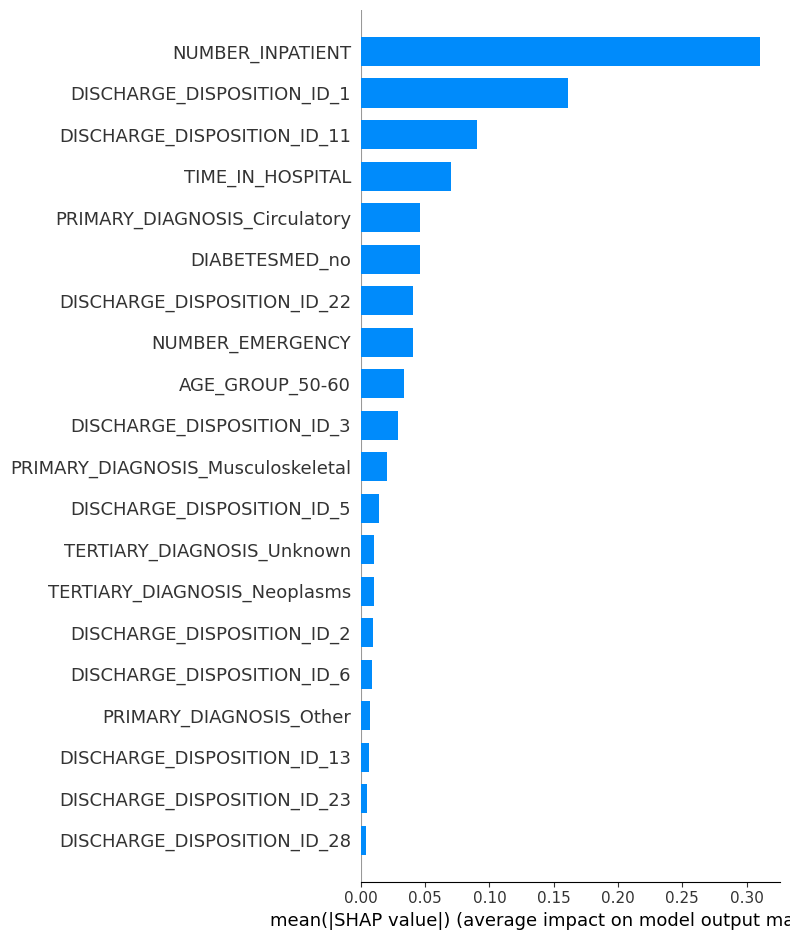

In [69]:
# Initialize SHAP explainer for the final best model
explainer = shap.TreeExplainer(xgb_best_final)
shap_values = explainer.shap_values(X_test_best)

# Global feature importance (bar chart)
shap.summary_plot(shap_values, X_test_best, plot_type="bar")


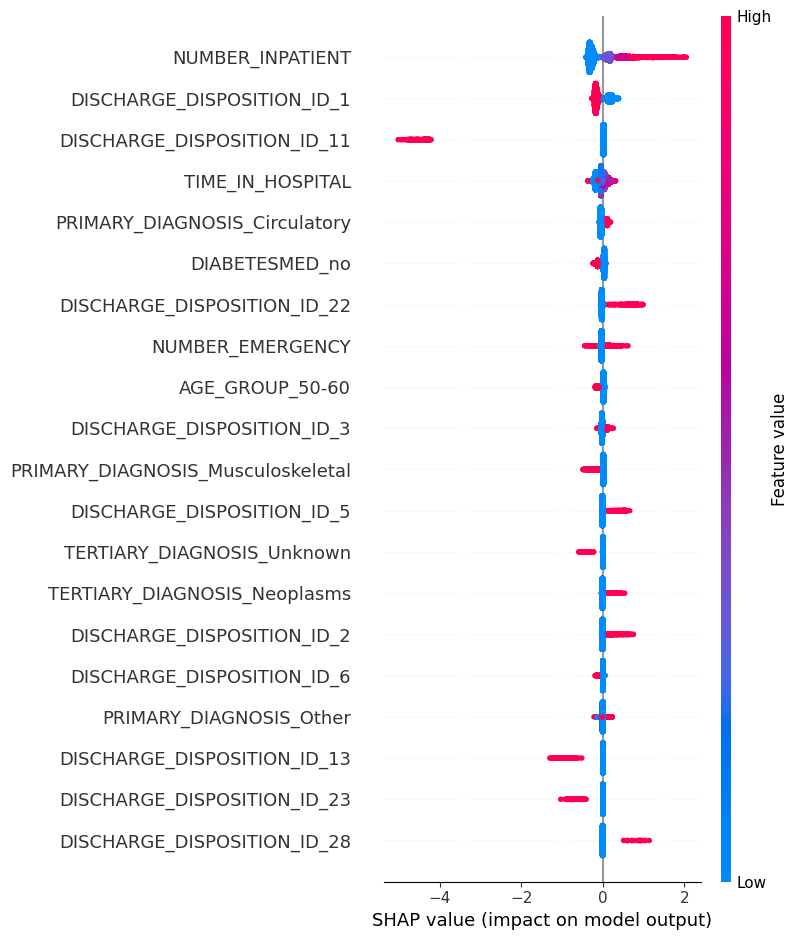

In [70]:
# Global distribution (beeswarm plot)
shap.summary_plot(shap_values, X_test_best)

In [71]:
# Local explanation (force plot for the first patient in test set)
shap.initjs()  # enables interactive JS visualization
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_test_best.iloc[0,:]
)